In [7]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

data = Dataset.load_builtin(name='ml-100k', prompt=False)

algo = SVD()

cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9419  0.9388  0.9328  0.9386  0.9364  0.9377  0.0030  
MAE (testset)     0.7423  0.7409  0.7348  0.7397  0.7374  0.7390  0.0026  
Fit time          0.88    0.89    0.86    0.84    0.87    0.87    0.02    
Test time         0.14    0.09    0.10    0.15    0.09    0.11    0.02    


{'test_rmse': array([0.94185257, 0.93877969, 0.93282094, 0.93861885, 0.9363598 ]),
 'test_mae': array([0.7422524 , 0.74092383, 0.73479602, 0.73971573, 0.7374008 ]),
 'fit_time': (0.8807039260864258,
  0.8860948085784912,
  0.862764835357666,
  0.8417391777038574,
  0.866788387298584),
 'test_time': (0.14094042778015137,
  0.09298443794250488,
  0.10395216941833496,
  0.14602994918823242,
  0.08997130393981934)}

In [8]:
from surprise import accuracy
from sklearn.metrics import mean_absolute_error
from surprise.model_selection import train_test_split

# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.25)

# We'll use the famous SVD algorithm.
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.9420


0.9420004931823233

In [9]:
from surprise.model_selection import GridSearchCV
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9643590775565917
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


In [11]:
from sigopt import Connection
conn = Connection(client_token="QCLCTADVQTUGJVOFIANJIQBJVBGTUNCAFBWZPRWPUPNHETPI")

In [12]:
experiment = conn.experiments().create(
  name='Surprise Movies-100k Recommender',
  # Define which parameters you would like to tune
  parameters=[
    dict(name='n_epochs', type='int', bounds=dict(min=5, max=10)),
    dict(name='lr_all', type='double', bounds=dict(min=0.002, max=0.005)),
    dict(name='reg_all', type='double', bounds=dict(min=0.4, max=0.6))
  ],
  metrics=[
    dict(name='RMSE', objective='minimize', strategy='optimize'),
    dict(name='MAE', objective='minimize', strategy='store')
  ],
  parallel_bandwidth=1,
  # Define an Observation Budget for your experiment
  observation_budget=50,
)
print("Created experiment: https://app.sigopt.com/experiment/" + experiment.id)

Created experiment: https://app.sigopt.com/experiment/1025245


In [15]:
def create_model(assignments):
  algo = SVD(
      n_epochs=assignments['n_epochs'],
      lr_all=assignments['lr_all'],
      reg_all=assignments['reg_all']
  ).fit(trainset)
  return algo

def evaluate_model(assignments):
  algo = create_model(assignments)
  predictions = algo.test(testset)
  # Then compute RMSE and MAE:
  return [
      dict(name="RMSE", value=accuracy.rmse(predictions)),
      dict(name="MAE", value=accuracy.mae(predictions))
    ]

while experiment.progress.observation_count < experiment.observation_budget:
  suggestion = conn.experiments(experiment.id).suggestions().create()
  value_dicts = evaluate_model(suggestion.assignments)
  conn.experiments(experiment.id).observations().create(
    suggestion=suggestion.id,
    values=value_dicts,
  )

  # Update the experiment object
  experiment = conn.experiments(experiment.id).fetch()

# Fetch the best configuration and explore your experiment
all_best_assignments = conn.experiments(experiment.id).best_assignments().fetch()
# Returns a list of dict-like Observation objects
best_assignments = all_best_assignments.data[0].assignments
print("Best Assignments: " + str(best_assignments))
print("Explore your experiment: https://app.sigopt.com/experiment/" + experiment.id + "/analysis")

RMSE: 0.9740
MAE:  0.7844
RMSE: 0.9841
MAE:  0.7950
RMSE: 0.9803
MAE:  0.7905
RMSE: 0.9889
MAE:  0.7991
RMSE: 0.9713
MAE:  0.7819
RMSE: 0.9748
MAE:  0.7858
RMSE: 0.9712
MAE:  0.7814
RMSE: 0.9665
MAE:  0.7766
RMSE: 0.9657
MAE:  0.7756
RMSE: 0.9746
MAE:  0.7837
RMSE: 0.9646
MAE:  0.7745
RMSE: 0.9785
MAE:  0.7881
RMSE: 0.9862
MAE:  0.7972
RMSE: 0.9946
MAE:  0.8057
RMSE: 0.9720
MAE:  0.7816
RMSE: 0.9710
MAE:  0.7809
RMSE: 0.9924
MAE:  0.8034
RMSE: 0.9926
MAE:  0.8027
RMSE: 0.9693
MAE:  0.7789
RMSE: 0.9769
MAE:  0.7867
RMSE: 0.9800
MAE:  0.7890
RMSE: 0.9720
MAE:  0.7828
RMSE: 0.9698
MAE:  0.7801
RMSE: 0.9744
MAE:  0.7852
RMSE: 0.9948
MAE:  0.8057
RMSE: 0.9784
MAE:  0.7897
RMSE: 0.9750
MAE:  0.7861
RMSE: 0.9973
MAE:  0.8074
RMSE: 0.9826
MAE:  0.7916
RMSE: 0.9886
MAE:  0.7977
RMSE: 0.9748
MAE:  0.7842
RMSE: 0.9744
MAE:  0.7844
RMSE: 0.9718
MAE:  0.7817
RMSE: 0.9660
MAE:  0.7758
RMSE: 0.9751
MAE:  0.7845
RMSE: 0.9671
MAE:  0.7768
RMSE: 0.9806
MAE:  0.7897
RMSE: 0.9706
MAE:  0.7800
RMSE: 0.9739

d:\jupyter\projects\Lib\site-packages\sigopt\objects.py:338: RuntimeWarning: The .data field only contains a single page of results, which may be incomplete for large responses. Prefer to use the `.iterate_pages() to ensure that you iterate through all elements in the response.
  warnings.warn(


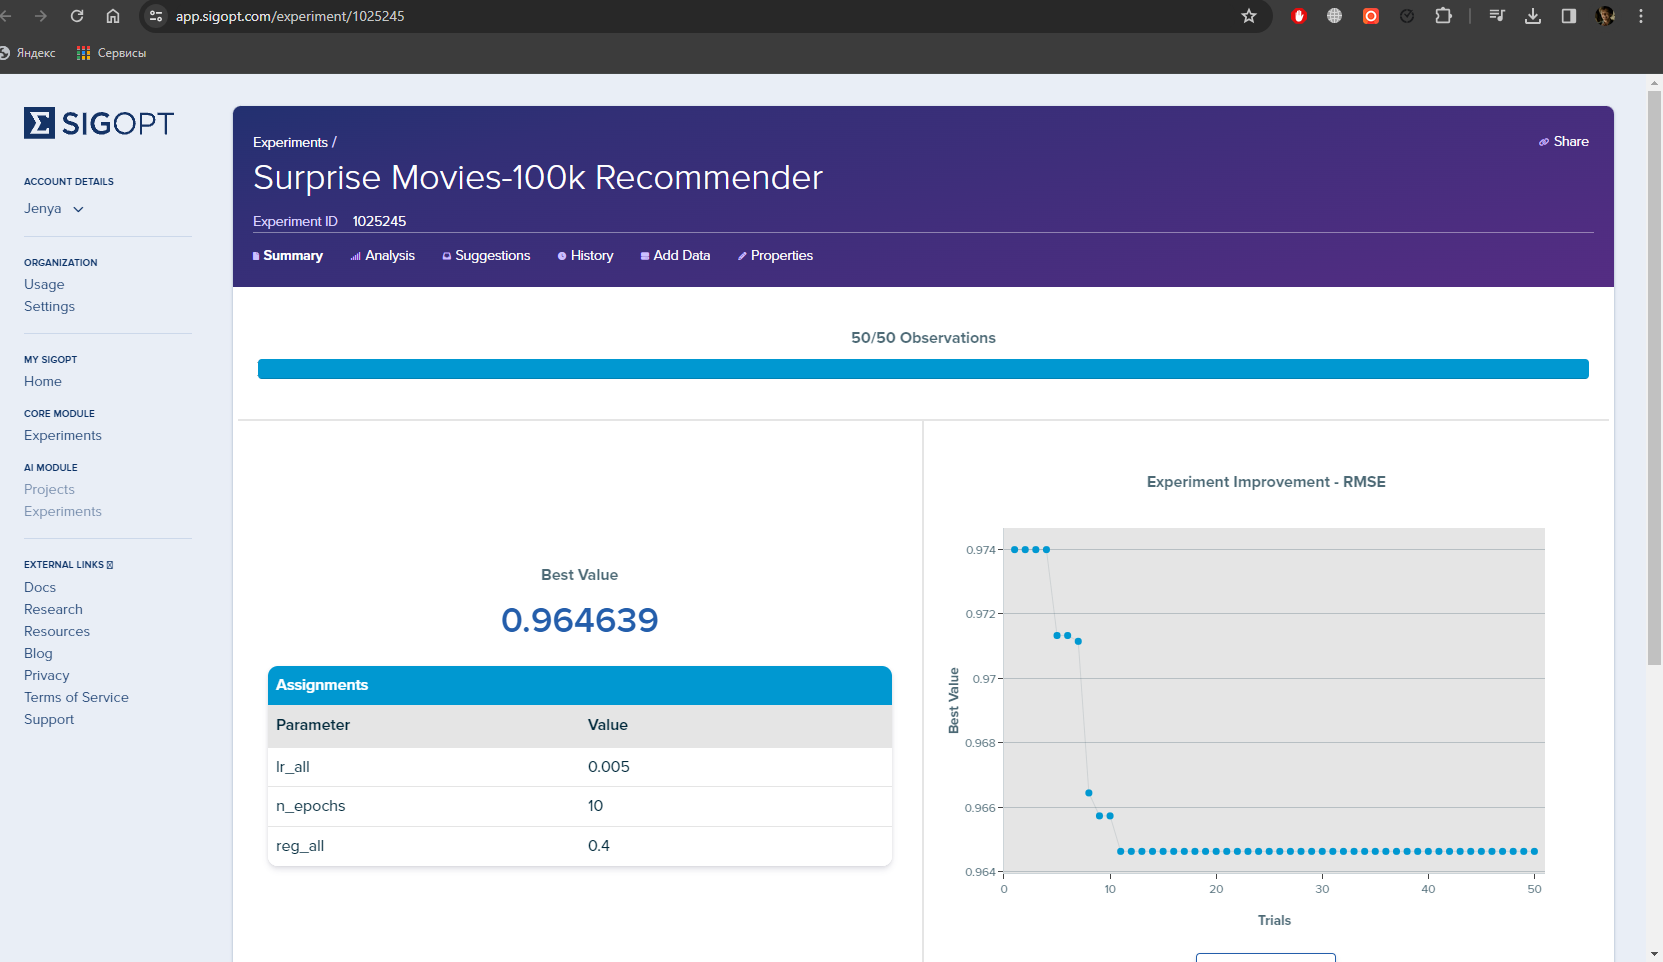